# Code written by: Manedge / xManedge


PCA and the standard autoencoder are unsupervised dimensionality reduction methods, and their learned features are not discriminative. If you build a classifier upon the low-dimenional features extracted by PCA and autoencoder, you will find the classification accuracy very poor.

Linear discriminant analysis (LDA) is a traditionally supervised dimensionality reduction method for learning low-dimensional features which are highly discriminative. Likewise, can we extend autoencoder to supervised learning?

# Goals

1. Build a standard dense autoencoder, visualize the low-dim features and the reconstructions, and evaluate whether the learned low-dim features are discriminative.

2. Repeat the above process by training a supervised autoencoder.


## Data preparation

### Load data

In [1]:
from torch.nn.functional import one_hot
from torchvision.datasets import MNIST
import torch
from torchviz import make_dot
import numpy as np
from matplotlib import pyplot as plt
from torchsummary import summary
from torch.utils.data import DataLoader, TensorDataset
from torchmetrics import Accuracy

In [2]:
# device selection - this enables the gpu
device = torch.device("mps") if torch.backends.mps.is_available() else "cpu"
device

device(type='mps')

In [3]:
trainset = MNIST(root='./data', download=True, train=True)
testset = MNIST(root='./data', download=True, train=False)

xtrain, ytrain = trainset.data.reshape(60000,784)/255.0, trainset.targets
xtest, ytest = testset.data.reshape(10000, 784), testset.targets

xtrain = xtrain.to(device=device)
xtest = xtest.to(device=device)
ytrain = ytrain.to(device=device)
ytest = ytest.to(device=device)

print('Shape of x_train: ' + str(xtrain.shape))
print('Shape of x_test: ' + str(xtest.shape))
print('Shape of y_train: ' + str(ytrain.shape))
print('Shape of y_test: ' + str(ytest.shape))


Shape of x_train: torch.Size([60000, 784])
Shape of x_test: torch.Size([10000, 784])
Shape of y_train: torch.Size([60000])
Shape of y_test: torch.Size([10000])


### One-hot encode the labels

In [4]:
def to_one_hot(y): 
    return one_hot(y)

In [5]:
print(ytrain[0])

ytrain = to_one_hot(ytrain).to(torch.float)
ytest = to_one_hot(ytest).to(torch.float)

print('Shape of y_train_vec: ' + str(ytrain.shape))
print('Shape of y_test_vec: ' + str(ytest.shape))


print(ytrain[0])

tensor(5, device='mps:0')
Shape of y_train_vec: torch.Size([60000, 10])
Shape of y_test_vec: torch.Size([10000, 10])
tensor([0., 0., 0., 0., 0., 1., 0., 0., 0., 0.], device='mps:0')


### Randomly partition the training set to training and validation sets


In [6]:
rand_indices = np.random.permutation(60000)
train_indices = rand_indices[0:10000]
valid_indices = rand_indices[10000:20000]

xval = xtrain[valid_indices, :]
yval = ytrain[valid_indices, :]

xtrain = xtrain[train_indices, :]
ytrain = ytrain[train_indices, :]

print('Shape of x_tr: ' + str(xtrain.shape))
print('Shape of y_tr: ' + str(ytrain.shape))
print('Shape of x_val: ' + str(xval.shape))
print('Shape of y_val: ' + str(yval.shape))

Shape of x_tr: torch.Size([10000, 784])
Shape of y_tr: torch.Size([10000, 10])
Shape of x_val: torch.Size([10000, 784])
Shape of y_val: torch.Size([10000, 10])


# Unsupervised Auto encoders

## Build the model

In [7]:
class AutoEncoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 512), 
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,2),
        )
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 512),
            torch.nn.ReLU(),
            torch.nn.Linear(512, input_size),
            torch.nn.Sigmoid(),
        )
    
    def forward(self, x):
        encoded = self.encoder(x)
        decoded = self.decoder(encoded)
        return decoded
    
    def encode(self, x):
        return self.encoder(x)
    
    def decode(self, encoded):
        return self.decoder(encoded)
    

In [8]:
model = AutoEncoder(input_size= xtrain.shape[1]).to(device=device)
model

AutoEncoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=512, bias=True)
    (1): ReLU()
    (2): Linear(in_features=512, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=32, bias=True)
    (5): ReLU()
    (6): Linear(in_features=32, out_features=2, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=128, bias=True)
    (3): ReLU()
    (4): Linear(in_features=128, out_features=512, bias=True)
    (5): ReLU()
    (6): Linear(in_features=512, out_features=784, bias=True)
    (7): Sigmoid()
  )
)

In [9]:
summary(model);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       401,920
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       65,664
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       4,128
|    └─ReLU: 2-6                         --
|    └─Linear: 2-7                       66
├─Sequential: 1-2                        --
|    └─Linear: 2-8                       96
|    └─ReLU: 2-9                         --
|    └─Linear: 2-10                      4,224
|    └─ReLU: 2-11                        --
|    └─Linear: 2-12                      66,048
|    └─ReLU: 2-13                        --
|    └─Linear: 2-14                      402,192
|    └─Sigmoid: 2-15                     --
Total params: 944,338
Trainable params: 944,338
Non-trainable params: 0


In [10]:
forwardpass = model(xtrain[0])
forwardpass
#make_dot(forwardpass, params=dict(list(model.named_parameters()))).render("auto encoder decoder", format="png")

tensor([0.5073, 0.4918, 0.4972, 0.4918, 0.5139, 0.4944, 0.5061, 0.4843, 0.4953,
        0.5111, 0.5123, 0.5279, 0.4990, 0.4988, 0.4887, 0.5195, 0.4979, 0.4804,
        0.5091, 0.5103, 0.4793, 0.5161, 0.4966, 0.5156, 0.4754, 0.5044, 0.5078,
        0.5011, 0.5010, 0.5227, 0.5121, 0.5015, 0.5131, 0.5007, 0.4956, 0.4908,
        0.5077, 0.4993, 0.4893, 0.4968, 0.4965, 0.4840, 0.5167, 0.4899, 0.5117,
        0.5045, 0.5024, 0.4971, 0.5148, 0.4713, 0.4854, 0.4915, 0.5106, 0.4952,
        0.5058, 0.4860, 0.5074, 0.5059, 0.5020, 0.4863, 0.5081, 0.5005, 0.5161,
        0.5088, 0.4921, 0.4914, 0.5025, 0.5065, 0.5092, 0.5045, 0.4937, 0.4789,
        0.4884, 0.5016, 0.5064, 0.5003, 0.5063, 0.5042, 0.5033, 0.5002, 0.4987,
        0.5042, 0.4865, 0.5197, 0.4913, 0.5076, 0.5177, 0.4790, 0.4843, 0.5070,
        0.4892, 0.5077, 0.5242, 0.5028, 0.5080, 0.5092, 0.5014, 0.5206, 0.5035,
        0.4879, 0.4900, 0.4970, 0.4904, 0.5074, 0.4961, 0.4981, 0.5023, 0.4924,
        0.4823, 0.5045, 0.4926, 0.5054, 

## Training the model 

In [11]:
# learning rate, optimizer selection
learning_rate = 1E-3 # to be tuned!
lossfn = torch.nn.MSELoss()
opt = torch.optim.Adam(
    model.parameters(),
    lr= learning_rate,
)

In [12]:
# loading the data into train loader, this segregates the data into batches, and trains the model form each batch 
# it removes the batches that are processed from memory, freeing up some space everytime
batch_size = 128
xtrainloader = DataLoader(xtrain, shuffle=True, batch_size=batch_size)

In [13]:
# this is the code for training the model 
# prints training loss and validation loss
epochs = 40
all_training_loss = []
all_val_loss = []

for epoch in range(epochs): 
    training_loss = 0
    for images in xtrainloader: 
        opt.zero_grad()
        new_images = model(images)
        loss = lossfn(new_images, images)
        loss.backward()
        opt.step()
        training_loss += loss.item() / len(xtrainloader)
    val_images = model(xval)
    all_training_loss.append(training_loss)
    val_loss = lossfn(val_images, xval).detach()
    all_val_loss.append(val_loss.cpu())
    print(f'''epoch [{epoch+1}/{epochs}]
        \t training loss: {training_loss},
        \t validation loss: {val_loss}''')
     
    

        

epoch [1/40]
        	 training loss: 0.08654054971058159,
        	 validation loss: 0.0634617879986763
epoch [2/40]
        	 training loss: 0.05899747036680388,
        	 validation loss: 0.05610840395092964
epoch [3/40]
        	 training loss: 0.05485769535733173,
        	 validation loss: 0.05373741313815117
epoch [4/40]
        	 training loss: 0.053162259721680497,
        	 validation loss: 0.05248056724667549
epoch [5/40]
        	 training loss: 0.051598225024682046,
        	 validation loss: 0.05075069144368172
epoch [6/40]
        	 training loss: 0.05007821241322953,
        	 validation loss: 0.04970116540789604
epoch [7/40]
        	 training loss: 0.04868438236321075,
        	 validation loss: 0.04842500016093254
epoch [8/40]
        	 training loss: 0.04755886993076227,
        	 validation loss: 0.0471305325627327
epoch [9/40]
        	 training loss: 0.04656862005402772,
        	 validation loss: 0.04613148793578148
epoch [10/40]
        	 training loss: 0.04549

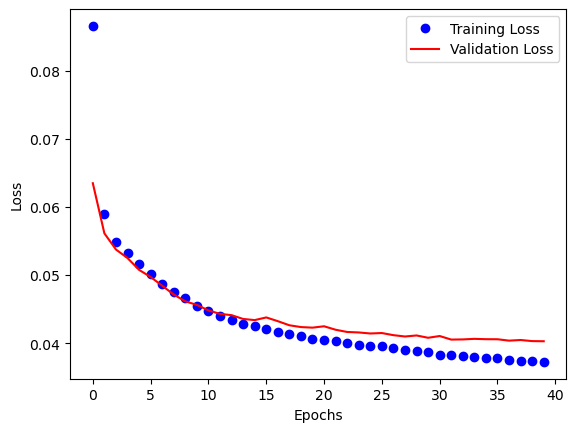

In [14]:
%matplotlib inline
epochs = range(epochs)
plt.plot(epochs, all_training_loss, 'bo', label='Training Loss')
plt.plot(epochs, all_val_loss, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize the reconstructed test images 

In [15]:
xtest.shape

torch.Size([10000, 784])

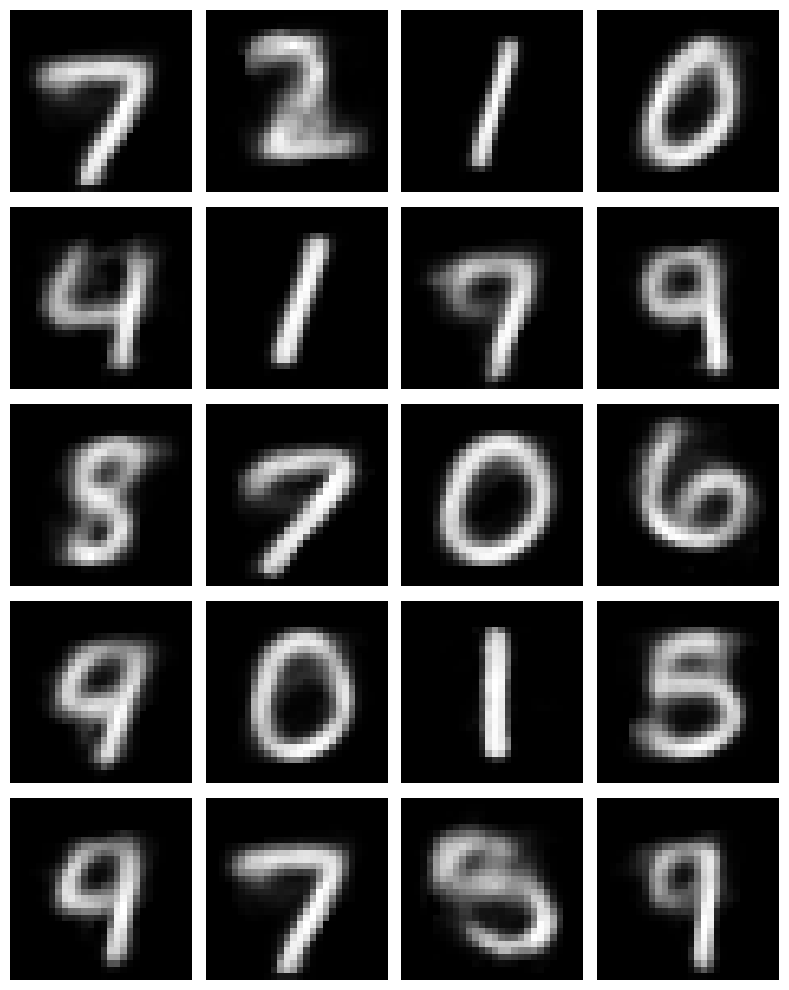

In [16]:
ae_output = model(xtest/255.0)

ROW = 5
COLUMN = 4

x = ae_output 
fname = 'reconstruct_ae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image.detach().cpu(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
#plt.savefig(fname)
plt.show()

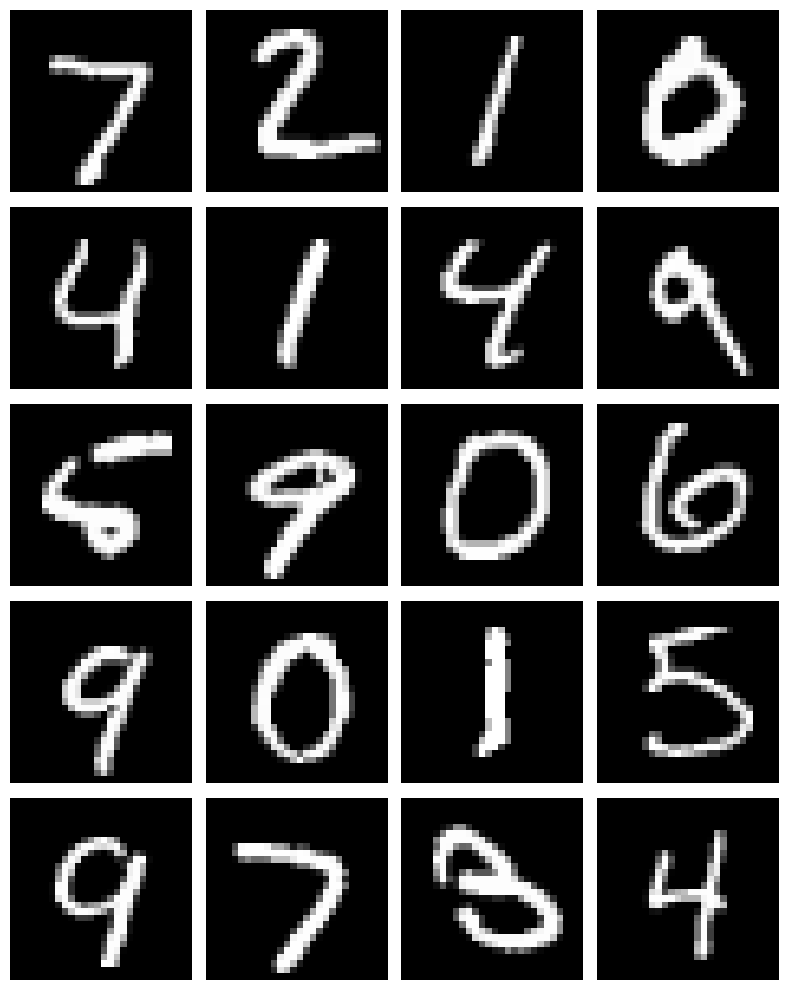

In [17]:
fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = xtest[i].reshape(28, 28)
    ax.imshow(image.detach().cpu(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

## Evaluate the model on the test set

In [18]:
reconstructedTest = model(xtest/255.0)
loss = lossfn(reconstructedTest, xtest/255.0)

print('loss = ' + str(loss))

loss = tensor(0.0404, device='mps:0', grad_fn=<MseLossBackward0>)


# Visualize the low-dimensional features

## build the encoder network

In [19]:
summary(model.encoder);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            401,920
├─ReLU: 1-2                              --
├─Linear: 1-3                            65,664
├─ReLU: 1-4                              --
├─Linear: 1-5                            4,128
├─ReLU: 1-6                              --
├─Linear: 1-7                            66
Total params: 471,778
Trainable params: 471,778
Non-trainable params: 0


In [20]:
# extract low-dimensional features from the test data
encoded_test = model.encode(xtest/255.0)
print('Shape of encoded_test: ' + str(encoded_test.shape))

Shape of encoded_test: torch.Size([10000, 2])


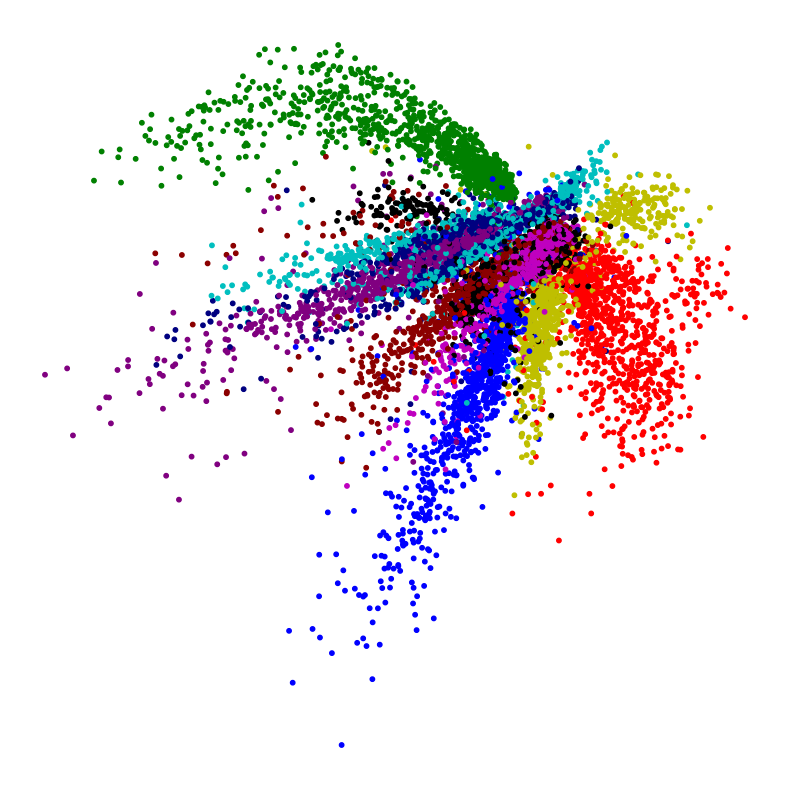

In [21]:
colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[testset.targets]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0].detach().cpu(), encoded_test[:, 1].detach().cpu(), s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'ae_code.pdf'
#plt.savefig(fname)

Judging from the visualization, the low-dim features seems decent but they're not very good. A model might not be able to classify them, so we move to supervised auto encoders

### Build the Supervised auto encoder

How supervised Auto encoders work! In the previous attempt we only tried to reconstruct the image using the actual input, as in the image itself. Attempting to train the model with the actual target variables might prove fruitful. We still place more imporantance to the actual image tho. So we create a new loss function that is the linear combination of the two previous weights. 

`Final Loss = Reconstruction Loss + 0.5 * Classifier Loss`

To prevent overfitting and explosion of values, we add batch norm 1D and dropout after most layers. BatchNorm is added after every layer and it is good practise to do so. Dropout is added after every layer that has a lot of neurons.

In [22]:
class supervised_auto_encoder(torch.nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(input_size, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(512, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(128,32),
            torch.nn.BatchNorm1d(32),
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(32,2), # bottleneck
        )

        self.reconstruction = torch.nn.Sequential(
            torch.nn.Linear(2, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Linear(32, 128),
            torch.nn.BatchNorm1d(128),
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 512),
            torch.nn.BatchNorm1d(512),
            torch.nn.Dropout(p=0.3),
            torch.nn.ReLU(),
            torch.nn.Linear(512, input_size),
            torch.nn.Sigmoid(),
        )

        self.classifier = torch.nn.Sequential(
            torch.nn.Linear(2,16),
            torch.nn.ReLU(),
            torch.nn.Linear(16,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,10),
            torch.nn.Softmax(dim=1)
        )


    def forward(self, x):
        encodedInput = self.encoder(x)
        reconstructedOutput = self.reconstruction(encodedInput)
        classifierOutput = self.classifier(encodedInput)
        return reconstructedOutput, classifierOutput

    def encode(self, x):
        return self.encoder(x)

    def decode(self, x):
        return self.reconstruction(x)

    def classify(self, x):
        return self.classifier(x)


In [23]:
SAE = supervised_auto_encoder(xtrain.shape[1]).to(device=device)
summary(SAE);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       401,920
|    └─BatchNorm1d: 2-2                  1,024
|    └─Dropout: 2-3                      --
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       65,664
|    └─BatchNorm1d: 2-6                  256
|    └─Dropout: 2-7                      --
|    └─ReLU: 2-8                         --
|    └─Linear: 2-9                       4,128
|    └─BatchNorm1d: 2-10                 64
|    └─Dropout: 2-11                     --
|    └─ReLU: 2-12                        --
|    └─Linear: 2-13                      66
├─Sequential: 1-2                        --
|    └─Linear: 2-14                      96
|    └─BatchNorm1d: 2-15                 64
|    └─ReLU: 2-16                        --
|    └─Linear: 2-17                      4,224
|    └─BatchNorm1d: 2-18                 256
|    └─Dropout: 2-19                     --
|    └─

In [24]:
# defining model parameters 
reconstructionLoss = torch.nn.MSELoss()
ClassifierLoss = torch.nn.CrossEntropyLoss()

lr = 1E-3
opt = torch.optim.Adam(SAE.parameters(), lr = lr)

In [25]:
# creating train loader for xtrain, ytrain, xtest, ytest
batch_size=32
training_loader = DataLoader(TensorDataset(xtrain, ytrain), batch_size=batch_size, shuffle=True)

In [26]:
epochs = 50
CLoss_weight = 0.5
RLoss_weight = 1
validation_loss_list = []
training_loss_list = []
accuracy = Accuracy(top_k=1, task='multiclass', num_classes=10).to(device=device)
for epoch in range(epochs):
    RLoss_running = 0
    CLoss_running = 0
    TotalLoss = 0
    for idx, data in enumerate(training_loader):
        inputs, labels = data
        opt.zero_grad()
        reconstructedImage, ClassifierOutput = SAE(inputs)

        # loss Calculations 
        REloss = reconstructionLoss(reconstructedImage, inputs)
        CLoss = ClassifierLoss(ClassifierOutput, labels)
        CLoss_running += CLoss.item()/len(training_loader)
        RLoss_running += REloss.item()/len(training_loader)

        # calculating final loss
        FinalLoss = CLoss_weight * CLoss + RLoss_weight * REloss
        TotalLoss += FinalLoss.item()/len(training_loader)


        FinalLoss.backward()
        opt.step()

    # validating 
    val_reconstructed, val_pred_labels = SAE(xval)

    # validation losses
    val_loss_RE, val_loss_Clf = reconstructionLoss(val_reconstructed, xval).detach(),ClassifierLoss(val_pred_labels, yval).detach()

    # val accuarcy 
    val_accuracy = accuracy(val_pred_labels, torch.argmax(yval, axis=1))


    final_val_loss = RLoss_weight * val_loss_RE + CLoss_weight * val_loss_Clf
    validation_loss_list.append(final_val_loss.cpu())
    training_loss_list.append(TotalLoss)

    # printing epoch metrics
    print(f'''epoch [{epoch+1}/{epochs}]
        \t training loss: {TotalLoss},
        \t validation loss: {final_val_loss},
        \t Val MSE Loss: {val_loss_RE},
        \t Val CLF loss: {val_loss_Clf},
        \t Val acc: {val_accuracy},
            ''')



epoch [1/50]
        	 training loss: 1.1023370046585133,
        	 validation loss: 0.9528224468231201,
        	 Val MSE Loss: 0.05418093875050545,
        	 Val CLF loss: 1.7972830533981323,
        	 Val acc: 0.6704000234603882,
            
epoch [2/50]
        	 training loss: 0.9166272267365987,
        	 validation loss: 0.879981517791748,
        	 Val MSE Loss: 0.051778774708509445,
        	 Val CLF loss: 1.6564054489135742,
        	 Val acc: 0.8169000148773193,
            
epoch [3/50]
        	 training loss: 0.8597234655112125,
        	 validation loss: 0.849176287651062,
        	 Val MSE Loss: 0.05098271742463112,
        	 Val CLF loss: 1.5963871479034424,
        	 Val acc: 0.867900013923645,
            
epoch [4/50]
        	 training loss: 0.8399817494157785,
        	 validation loss: 0.8369860053062439,
        	 Val MSE Loss: 0.05041981115937233,
        	 Val CLF loss: 1.5731323957443237,
        	 Val acc: 0.8898000121116638,
            
epoch [5/50]
     

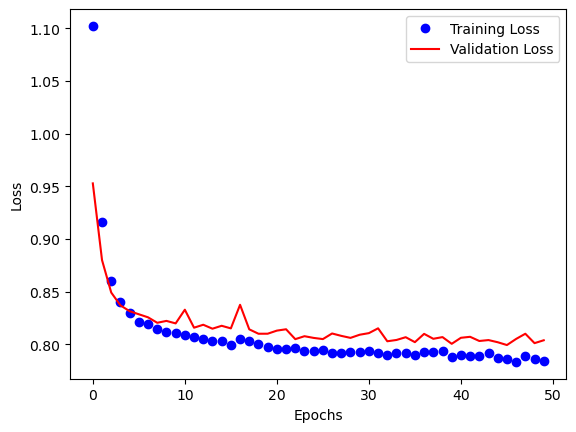

In [27]:
epochs = range(epochs)

plt.plot(epochs, training_loss_list, 'bo', label='Training Loss')
plt.plot(epochs, validation_loss_list, 'r', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Visualize the reconstructed test images

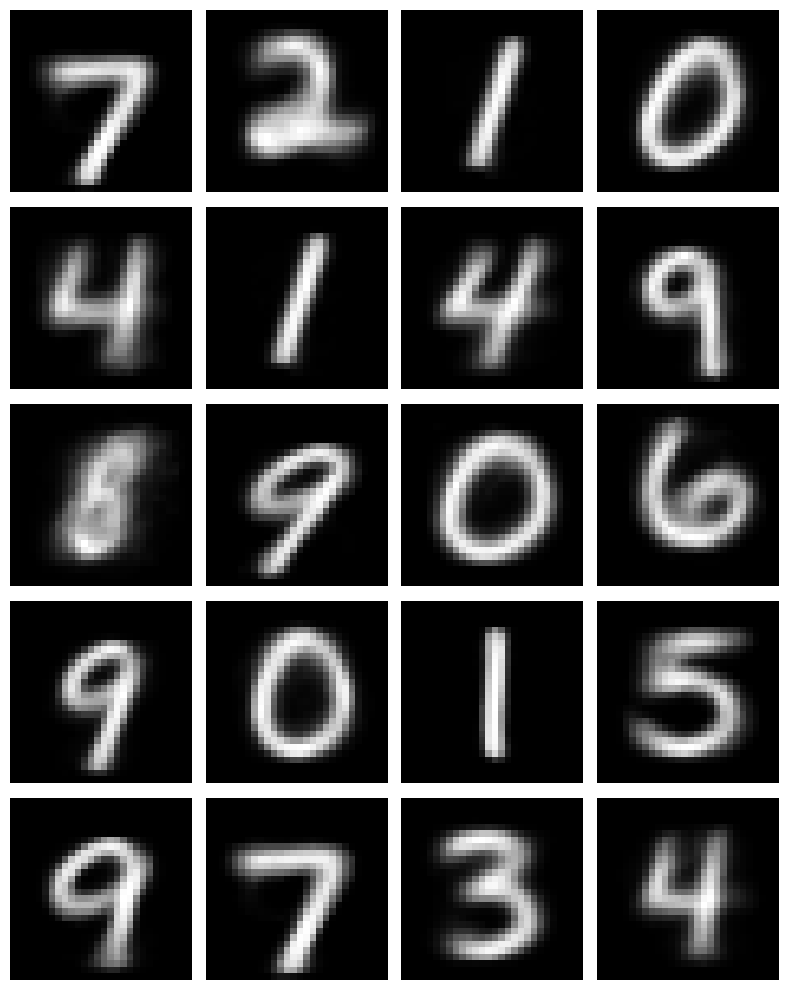

In [28]:
sae_output = SAE(xtest/255.0)[0].reshape(10000,28,28).detach().cpu()

ROW = 5
COLUMN = 4

x = sae_output
fname = 'reconstruct_sae.pdf'

fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = x[i].reshape(28, 28)
    ax.imshow(image, cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.savefig(fname)
plt.show()

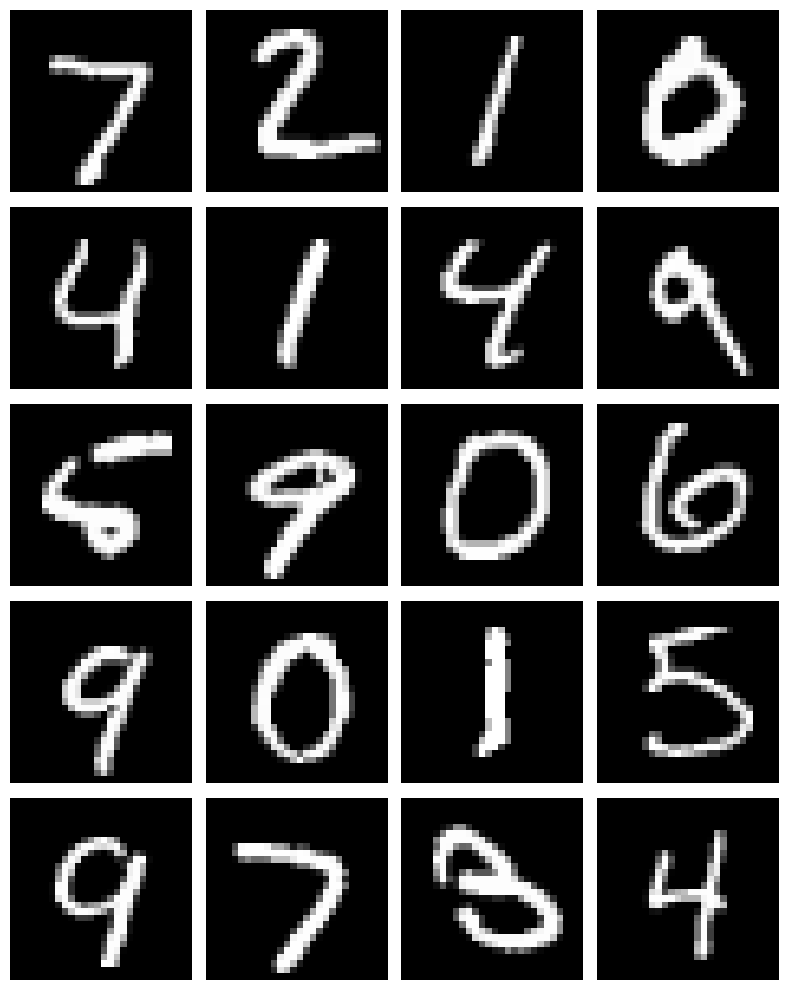

In [29]:
fig, axes = plt.subplots(nrows=ROW, ncols=COLUMN, figsize=(8, 10))
for ax, i in zip(axes.flat, np.arange(ROW*COLUMN)):
    image = xtest[i].reshape(28, 28)
    ax.imshow(image.detach().cpu(), cmap='gray')
    ax.axis('off')

plt.tight_layout()
plt.show()

### Visualize the low-dimensional features

In [30]:
summary(SAE.encoder);

Layer (type:depth-idx)                   Param #
├─Linear: 1-1                            401,920
├─BatchNorm1d: 1-2                       1,024
├─Dropout: 1-3                           --
├─ReLU: 1-4                              --
├─Linear: 1-5                            65,664
├─BatchNorm1d: 1-6                       256
├─Dropout: 1-7                           --
├─ReLU: 1-8                              --
├─Linear: 1-9                            4,128
├─BatchNorm1d: 1-10                      64
├─Dropout: 1-11                          --
├─ReLU: 1-12                             --
├─Linear: 1-13                           66
Total params: 473,122
Trainable params: 473,122
Non-trainable params: 0


Shape of encoded_test: torch.Size([10000, 2])


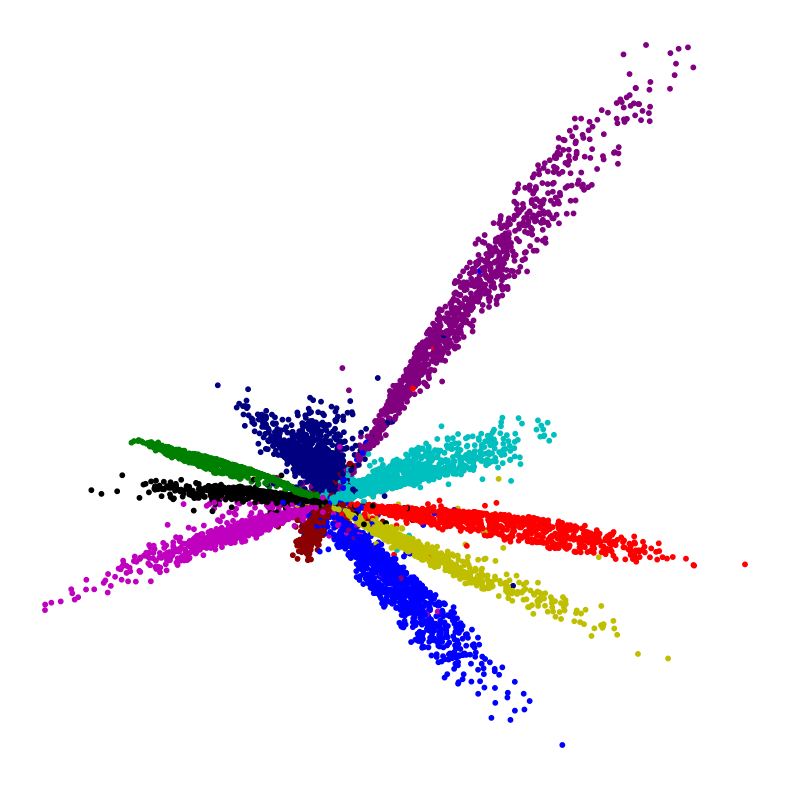

In [31]:
encoded_test = SAE.encode(xtest/255.0)
encoded_test = encoded_test.detach().cpu()
print('Shape of encoded_test: ' + str(encoded_test.shape))


colors = np.array(['r', 'g', 'b', 'm', 'c', 'k', 'y', 'purple', 'darkred', 'navy'])
colors_test = colors[testset.targets]


import matplotlib.pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(8, 8))
plt.scatter(encoded_test[:, 0], encoded_test[:, 1], s=10, c=colors_test, edgecolors=colors_test)
plt.axis('off')
plt.tight_layout()
fname = 'sae_code.pdf'
#plt.savefig(fname)

The features look mcuh more discriminative, but can a classifier model discriminate as well? 

# Build a classifier model

In [32]:
# creating encoded train, val, test version and loading them into a dataloader
encodedTrain, encodedVal = SAE.encode(xtrain).detach(), SAE.encode(xval).detach()
encodedTrain = torch.nn.functional.normalize(encodedTrain, dim=1)
encodedVal = torch.nn.functional.normalize(encodedVal, dim=1)

In [33]:
batch_size = 32
training_loader = DataLoader(TensorDataset(encodedTrain, ytrain), batch_size=batch_size, shuffle=True)

In [39]:
class classifier_model(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.classify = torch.nn.Sequential(
            torch.nn.Linear(2,32),
            torch.nn.ReLU(),
            torch.nn.Linear(32,64),
            torch.nn.ReLU(),
            torch.nn.Linear(64,10),
            torch.nn.Softmax(dim=1)
        )
    def forward(self, x):
        predoutput = self.classify(x)
        return predoutput

In [40]:
clf_model2 = classifier_model().to(device=device)
clf_model2

classifier_model(
  (classify): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
    (3): ReLU()
    (4): Linear(in_features=64, out_features=10, bias=True)
    (5): Softmax(dim=1)
  )
)

In [41]:
summary(clf_model2);

Layer (type:depth-idx)                   Param #
├─Sequential: 1-1                        --
|    └─Linear: 2-1                       96
|    └─ReLU: 2-2                         --
|    └─Linear: 2-3                       2,112
|    └─ReLU: 2-4                         --
|    └─Linear: 2-5                       650
|    └─Softmax: 2-6                      --
Total params: 2,858
Trainable params: 2,858
Non-trainable params: 0


In [42]:
# define model training parameters
lossfn = torch.nn.CrossEntropyLoss()
learning_rate = 1E-3
opt = torch.optim.Adam(
    clf_model2.parameters(),
    lr=learning_rate
)

In [43]:
epochs = 50
accuracy = Accuracy(top_k=1, task='multiclass', num_classes=10).to(device=device)
for epoch in range(epochs):
    running_loss = 0
    for idx, data in enumerate(training_loader):
        inputs, labels = data
        opt.zero_grad()
        outputs = clf_model2(inputs)
        loss = lossfn(outputs, labels)
        loss.backward()
        opt.step()
        running_loss += loss.item() / len(training_loader)

    # validation metrics

    all_training_loss.append(running_loss)

    predicted_val = clf_model2(encodedVal)
    val_loss = lossfn(predicted_val, yval).detach()
    all_val_loss.append(val_loss.cpu())
    val_acc = accuracy(predicted_val, torch.argmax(yval, axis=1))

    print(f'''epoch [{epoch+1}/{epochs}]
        \t training loss: {running_loss},
        \t validation loss: {val_loss},
        \t Val acc: {val_acc},
            ''')
    

epoch [1/50]
        	 training loss: 1.8984423605397862,
        	 validation loss: 1.598524808883667,
        	 Val acc: 0.9323999881744385,
            
epoch [2/50]
        	 training loss: 1.525440229775427,
        	 validation loss: 1.5414247512817383,
        	 Val acc: 0.9333000183105469,
            
epoch [3/50]
        	 training loss: 1.5012548190717108,
        	 validation loss: 1.5328760147094727,
        	 Val acc: 0.9348999857902527,
            
epoch [4/50]
        	 training loss: 1.4958777953260616,
        	 validation loss: 1.5298787355422974,
        	 Val acc: 0.9351999759674072,
            
epoch [5/50]
        	 training loss: 1.4937550286515464,
        	 validation loss: 1.5280187129974365,
        	 Val acc: 0.9352999925613403,
            
epoch [6/50]
        	 training loss: 1.4924686926241484,
        	 validation loss: 1.527665615081787,
        	 Val acc: 0.9348999857902527,
            
epoch [7/50]
        	 training loss: 1.4917466945160687,
   

In [44]:
encodedTest = SAE.encode(xtest/255.0)
encodedTest = torch.nn.functional.normalize(encodedTest, dim=1)

In [45]:
ypred = clf_model2(encodedTest)
print(accuracy(ypred, torch.argmax(ytest,axis=1)))

tensor(0.9423, device='mps:0')


The accuracy is close to what we would get if we did not use auto encoders to lower dim space. Proves that supervised auto encoders are really good! But in what case would they not be discriminative? Maybe in a scenario where you shouldn't cluster based on Target value. cant think of any right now. 

Could have also used a CNN instead of a dense Layer in the auto encoders to extract features, eventually using a flatten to feed into a dense network. Chose against it, cause mnist is a simple dataset and this is a proof of concept. 